# Analog Hamiltonian simulation with PennyLane

We are excited to announce that customers can now run analog Hamiltonian simulation (AHS) on Braket’s Rydberg atom devices via the [PennyLane-Braket SDK plug-in](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/). Rydberg atom devices, such as [QuEra’s Aquila device](https://aws.amazon.com/blogs/quantum-computing/amazon-braket-launches-aquila-the-first-neutral-atom-quantum-processor-from-quera-computing/), feature customizable qubit geometry and time-dependent parameter control that allow you to engineer the system’s quantum evolution with high precision. This low-level control allows one to optimize the time-dependent parameters in an AHS program to simulate, for example, [quantum phases of matter](https://aws.amazon.com/blogs/quantum-computing/realizing-quantum-spin-liquid-phase-on-an-analog-hamiltonian-rydberg-simulator/) (see [here](https://github.com/aws/amazon-braket-examples/tree/main/examples/analog_hamiltonian_simulation) for more examples). However, searching for the optimal parameters can be tedious. With this new feature from the PennyLane-Braket plug-in, users can leverage the quantum machine learning techniques from [PennyLane](https://pennylane.ai/) to optimize their AHS programs for the Rydberg atom device.

## Analog Hamiltonian simulation with Rydberg atoms

AHS is an approach to study the properties of a quantum system by tuning the parameters of another quantum system that closely resembles the system of interest. In an AHS program, it is often required to find a set of parameters and minimize a cost function. Various methods to do this have been studied in the literature, including [stochastic optimizers](https://arxiv.org/abs/2202.09372), [Bayesian optimizations](https://arxiv.org/abs/2305.13365) and more. In this blog post, we demonstrate how to optimize the parameters for Rydberg atom devices using the [differentiable programming technique](https://pennylane.ai/qml/demos/tutorial_pulse_programming101), another recently released feature on PennyLane.

As an example, let us consider a chain with nine spins, each of which can be in "up" or "down" states. We are interested in studying the so-called [anti-ferromagnetic (AFM) order](https://en.wikipedia.org/wiki/Antiferromagnetism), a naturally occurring phenomena in magnetic materials, where neighboring spins point in the opposite directions. To simulate the spin chain, we map each spin to an atom, and the ground and excited Rydberg states of each atom correspond to the "down" and "up" states of the spin, respectively. With this encoding, the AFM order of interest corresponds to an alternating pattern of ground and Rydberg states for the chain of nine atoms. We will show how to realize such a configuration in Rydberg system using PennyLane. 

We first create an arrangement with nine atoms by explicitly specifying their coordinates.


In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

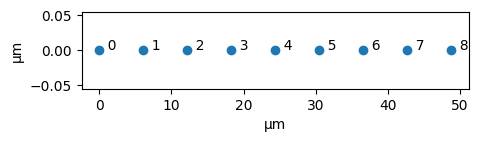

In [2]:
import matplotlib.pyplot as plt

# For realizing the AFM order, the atomic spacing is typically
# chosen between 6 and 7 micrometers. The interested readers are 
# encouraged to try other values of atomic spacing!
a = 6.1 # μm
num_atoms = 9
coords = []
for k in range(num_atoms):
    coords.append([k * a, 0])

plt.figure(figsize=(5,1))    

plt.scatter([x for x, y in coords], [y for x, y in coords])

# Add the labels for the atoms            
for idx, site in enumerate(coords):
    plt.text(site[0], site[1], f"  {idx}", fontsize=10)

plt.xlabel("μm")
plt.ylabel("μm")
plt.show()


We note that the atom spacing is specified in the unit of micrometers ($\mu m$), following the convention of PennyLane. At the beginning of the AHS program, all the atoms are initialized in the ground state, and we aim to tune the time-dependent parameters of the system, including the amplitude of the Rabi frequency and detuning, to drive the system to the AFM state. An example of such an AHS program has been demonstrated in [this AHS example notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/02_Ordered_phases_in_Rydberg_systems.ipynb), where the time-series of the driving fields are specified as discrete sets of time-value pairs. Here, on the other hand, we will specify the time-series of the driving fields as continuous, differentiable functions.

## Creating a differentiable Hamiltonian with PennyLane

A [driving field]((https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/00_Introduction_of_Analog_Hamiltonian_Simulation_with_Rydberg_Atoms.ipynb)) in an AHS program consists of the amplitude (Rabi frequency), laser phase and the detuning of the driving laser field. To create a differentiable driving field, let us first specify some constraints, such as the maximum allowed values for the amplitude and detuning. We will set the laser phase to be constantly zero in this example.

In [3]:
import pennylane.numpy as np

# Rydberg interaction constant
C6 = 862619.79 # MHz μm^6

# Constraints for the driving fields with SI unit, the unit used by Braket
amplitude_max = 1.58e7 # rad/second
detuning_max = 1.25e8 # rad/second
time_max_second = 4e-6 # second


def angular_SI_to_MHz(angular_SI):
    """Converts a value in rad/s or (rad/s)/s into MHz or MHz/s"""
    return angular_SI / (2 * np.pi) * 1e-6

# Pennylane uses microseconds for time so the unit of time is converted from second to microsecond
time_max = time_max_second * 1e6 # microsecond

# Pennylane uses MHz for amplitude and detuning so their units are converted from rad/second to MHz
amplitude_max = angular_SI_to_MHz(amplitude_max) # MHz
detuning_max = angular_SI_to_MHz(detuning_max) # MHz

print(f"amplitude_max = {round(amplitude_max, 2)} MHz")
print(f"detuning_max  = {round(detuning_max, 2)} MHz")
print(f"time_max      = {time_max} μs")


amplitude_max = 2.51 MHz
detuning_max  = 19.89 MHz
time_max      = 4.0 μs


Following the convention of PennyLane, we have used megahertz (MHz) as the unit for the amplitude and detuning. Also, we have limited the maximum duration of the program, `time_max`, to be 4$\mu s$, and introduced the Rydberg interaction constant $C_6$. These constants are specific to QuEra's Aquila, and they can be queried from Braket SDK, as shown in [this AHS example notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/01_Introduction_to_Aquila.ipynb). With these constants, the differentiable driving fields for the Rydberg atom device can be defined via [PennyLane's JAX interface](https://pennylane.ai/qml/demos/tutorial_jax_transformations).

In [4]:
import jax.numpy as jnp
import jax

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_debug_nans", True)

def ryd_amplitude(p, t):
    """Parametrized function for amplitude"""
    return p[0] * (1-(1-jnp.sin(jnp.pi * t/time_max)**2)**(p[1]/2))

def ryd_detuning(p, t):
    """Parametrized function for detuning"""
    return p[0] * jnp.arctan(p[1] * (t-time_max/2)) / (jnp.pi/2)


There are two important remarks for defining the differentiable functions in PennyLane. First, mathematical functions, such as trigonometric functions, should be explicitly defined as JAX functions for them to be differentiable. Second, the callable functions, such as `ryd_amplitude`, are defined to have signature `(p, t)`, which is required when defining the [ParametrizedHamiltonian](https://docs.pennylane.ai/en/latest/code/api/pennylane.pulse.ParametrizedHamiltonian.html) object for the Rydberg atom device (see `H_ryd` below). 

The function `ryd_amplitude` starts and ends at zero, as required for the amplitude of the Rabi frequency for QuEra's Aquila (see [this AHS example notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/01_Introduction_to_Aquila.ipynb) for more details). We start the detuning, as parametrized by `ryd_detuning`, at a negative value to ensure that the initial state (where all atoms are in the ground state) is the lowest energy state of the Hamiltonian. Upon gradually increasing the detuning to a positive value, the Rydberg system is adiabatically driven to the AFM order (see below for the cost function for the AFM order). As an example, we define a set of parameters for the driving fields and plot them.


/tmp/ipykernel_15094/744165201.py:11: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  return p[0] * (1-(1-jnp.sin(jnp.pi * t/time_max)**2)**(p[1]/2))


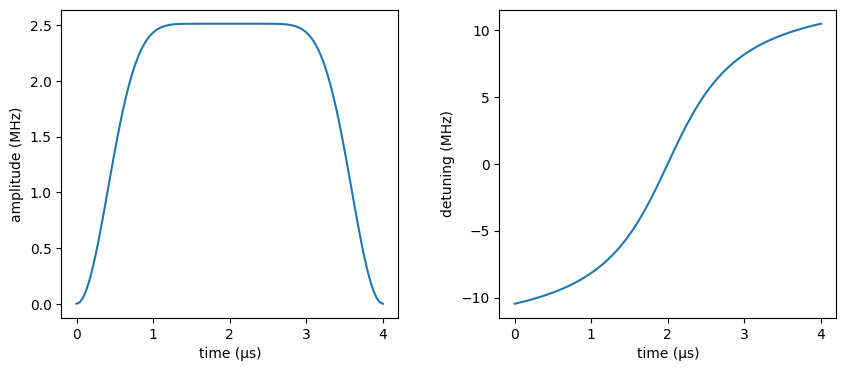

In [5]:
vis_time = np.linspace(0, time_max, 100)

# These parameters are chosen arbitrarily for demonstration purpose.
# The readers are encouraged to try out other parameters!
amplitude_param = [amplitude_max, 10]
detuning_param = [detuning_max * 2/3, 1.45]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(vis_time, [ryd_amplitude(amplitude_param, t) for t in vis_time])
axes[0].set_xlabel("time (μs)")
axes[0].set_ylabel("amplitude (MHz)")
axes[1].plot(vis_time, [ryd_detuning(detuning_param, t) for t in vis_time])
axes[1].set_ylabel("detuning (MHz)")
axes[1].set_xlabel("time (μs)")
fig.subplots_adjust(wspace=0.3)
plt.show()


We construct the parametrized function for the global driving field for the Rydberg atoms out of the amplitude and detuning functions.

In [6]:
import pennylane as qml

global_drive = qml.pulse.rydberg_drive(amplitude=ryd_amplitude,
                                       phase=0,
                                       detuning=ryd_detuning,
                                       wires=range(len(coords)))


For simplicity, we have fixed the `phase`, another time-dependent parameter for Rydberg devices, to be zero. The full Rydberg Hamiltonian is the sum of the driving field and the Rydberg interaction.

In [7]:
H_ryd = global_drive + qml.pulse.rydberg_interaction(coords, interaction_coeff=C6)

## Simulating anti-ferromagnetic order with Rydberg atoms

We have created a time-dependent, parameterized Rydberg Hamiltonian. Now let us check if it can realize the AFM order. For that, we define the following parametrized AHS program.


In [8]:
ts = [0, time_max]

def program(detuning_param, amplitude_param = amplitude_param, ts = ts):
    qml.evolve(H_ryd)([amplitude_param, detuning_param], ts)
    return qml.counts()


Here [qml.evolve](https://docs.pennylane.ai/en/stable/code/api/pennylane.evolve.html) returns a [ParametrizedEvolution](https://docs.pennylane.ai/en/stable/code/api/pennylane.pulse.ParametrizedEvolution.html) object which has the same set of parameters as the parametrized Hamiltonian `H_ryd`. The `program` takes in the parameters for detuning, the only necessary parameters, and outputs the measurement outcome of the AHS program. Below, we will optimize the parameters of the detuning while keeping those for the amplitude fixed. The AHS program can be run on the PennyLane simulator as follows.

In [9]:
shots = 1000

# Introduce the PennyLane local simulator
simulator_pl = qml.device("default.qubit.jax", wires=len(coords), shots=shots)

# Define the qnode that runs the AHS program
program_pl = qml.QNode(program, simulator_pl, interface="jax")

# Run the program with a specific set of parameters for the detuning
counts_pl = program_pl(detuning_param)


We plot the probability of Rydberg state for each site, averaged over all the shots, for the results from the PennyLane and AWS local simulators.

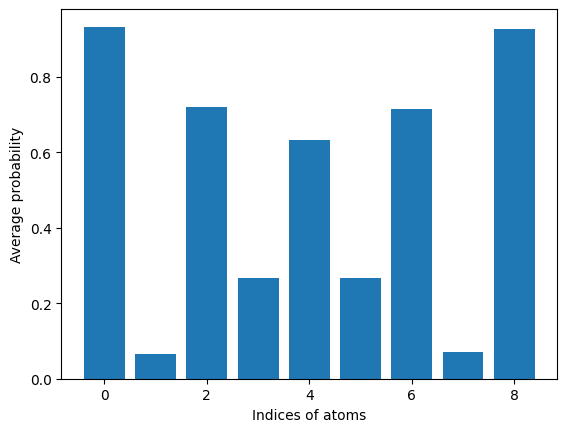

In [10]:
def get_prob(counts):
    """Helper function for calculating the Rydberg probability averaged over all the shots"""
    prob = np.zeros(9)
    total_shots = 0 # Total number of shots in the counts
    for key, val in counts.items():
        prob += np.array([int(bit) for bit in [*key]]) * val
        total_shots += val
    prob /= total_shots
    return prob

prob_pl = get_prob(counts_pl)

fig, axs = plt.subplots(1, 1)
axs.bar(range(len(coords)), prob_pl)
axs.set_xlabel("Indices of atoms")
axs.set_ylabel("Average probability")
plt.show()


Below we will focus on the PennyLane local simulator, which supports the JAX interface for differentiable programming. 

For a chain of atoms, the average Rydberg probability of the ideal AFM order forms an alternating pattern of zeros and ones. In particular, atoms in the odd-index and even-index sites tend to be in the ground and Rydberg states, respectively. From the above plots, we see that the AHS program approximately produces the AFM state of interest. The discrepancy, which is more prominent at the center of the chain, can be attributed to the non-adiabaticity during the evolution. The AFM order obtained can be improved further by tuning, the detuning field, however,but manually searching through the parameter space is expensive. We now show that the differentiable programming can be helpful in this scenario. 

## Cost function for anti-ferromagnetic order

To optimize the AHS program, we need to define a cost function, which characterizes the "quality" of the AFM order. The cost function is defined as follows (the label of atoms starts from $0$)
\begin{align}
H_\text{cost} = \sum_{i=0}^7\left(x_i-\frac{1}{2}\right)\left(x_{i+1}-\frac{1}{2}\right).
\end{align}
We will use binary variables $x_i$ to represent the states of the atoms: $x_i=1$ when the $i$-th atom is in the Rydberg state, otherwise $x_i=0$. When two neighboring atoms occupy ground and Rydberg states respectively, they form a domain wall, and the above cost function counts the number of domain walls in the atomic chain. For an ideal AFM order, each domain wall contributes $-\frac{1}{4}$ to the cost function, and for the nine-atom chain, the cost function is evaluated to be $H_\text{cost}=-2$. 

The cost function can be specified as follows.


In [11]:
# Initialize the cost function
H_cost = 0
for i in range(len(coords)-2):
    # Add the contribution from each domain wall
    H_cost += qml.prod(qml.Projector([1], wires=[i]) - 1/2, qml.Projector([1], wires=[i+1]) -1/2)


Here we use the [Projector](https://docs.pennylane.ai/en/stable/code/api/pennylane.Projector.html) in PennyLane to represent the Boolean variables. For example, `qml.Projector([0], wires=[1])` represents $x_1=0$  and `qml.Projector([1], wires=[2])` represents $x_2=1$. The product between the Boolean variables is realized with [qml.prod](https://docs.pennylane.ai/en/stable/code/api/pennylane.prod.html).

## Variational analog Hamiltonian simulation program with PennyLane

With the cost Hamiltonian defined, we can create a variational AHS program, which evolves the Rydberg system followed by measuring the cost function $H_\text{cost}$.


In [12]:
# Define the PennyLane local simulator
dev = qml.device("default.qubit.jax", wires=range(len(coords)))

# Define the qnode that evolves the Rydberg system, followed by calculating the cost function
@qml.qnode(dev, interface="jax")
def program_cost(detuning_param, amplitude_param = amplitude_param, ts = ts):
    qml.evolve(H_ryd)([amplitude_param, detuning_param], ts)
    return qml.expval(H_cost)


We note again that `program_cost` is a parametrized AHS program that has only one positional argument, the parameters for the detuning, and outputs the cost function $H_\text{cost}$. With the JAX interface, we can optimize the detuning to minimize the cost function. We use `detuning_param` defined above as the initial parameter for the optimization.

In [13]:
theta = detuning_param.copy() 
initial_cost = program_cost(theta)
print(f"The initial parameter for detuning = {theta}")
print(f"The initial cost value             = {initial_cost}")


The initial parameter for detuning = [13.262911924324612, 1.45]
The initial cost value             = -1.4220786805245207


We see that the initial cost function is evaluated to be approximately $-1.422$, which is larger than $-2$, the expected value for the ideal AFM order. This is consistent with our finding that the corresponding state is not an ideal AFM order. To minimize the cost function $H_\text{cost}$, we first introduce a JAX function that calculates the expectation value and its gradient.

In [14]:
value_and_grad = jax.jit(jax.value_and_grad(program_cost))

# Compile the value_and_grad function
_, _ = value_and_grad(theta)


Next, we define the learning rate schedule, followed by using the `adam` implementation in [optax](https://optax.readthedocs.io/en/latest/) for optimization.

In [15]:
import optax

n_epochs = 10

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(1e-1)
schedule1 = optax.constant_schedule(5e-1)
schedule = optax.join_schedules([schedule0, schedule1], [10])
optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(theta)


Now we are ready to run the optimization.

In [16]:
energy = np.zeros(n_epochs + 1)
energy[0] = program_cost(theta)
gradients = np.zeros(n_epochs)

## Optimization loop
print("epoch  expectation")
for n in range(n_epochs):
    val, grad_program = value_and_grad(theta)
    updates, opt_state = optimizer.update(grad_program, opt_state)
    theta = optax.apply_updates(theta, updates)

    energy[n + 1] = val
    gradients[n] = np.mean(np.abs(grad_program))

    print(n, "   ", val)
    
print(f"The final parameter for detuning = {[float(i) for i in theta]}")


epoch  expectation
0     -1.4220786805245293
1     -1.4440255545399934
2     -1.4682669156813517
3     -1.494929936649468
4     -1.52414541861693
5     -1.5561124234490418
6     -1.590274680470023
7     -1.6261105967628833
8     -1.6618436930215126
9     -1.695197967500683
The final parameter for detuning = [12.268508609205842, 0.4353973115231312]


We see that the expectation $H_\text{cost}$ is indeed gradually decreasing as expected. In order to reach the expected valued $-2$, we encourage the interested readers to try larger number of epochs or different optimization schedules. By construction, a larger absolute value of $H_\text{cost}$ corresponds to a sharper alternating pattern for the Rydberg probability. To confirm that, we calculate the Rydberg probability with the optimized detuning, followed by comparing the Rydberg probability before and after the optimization.

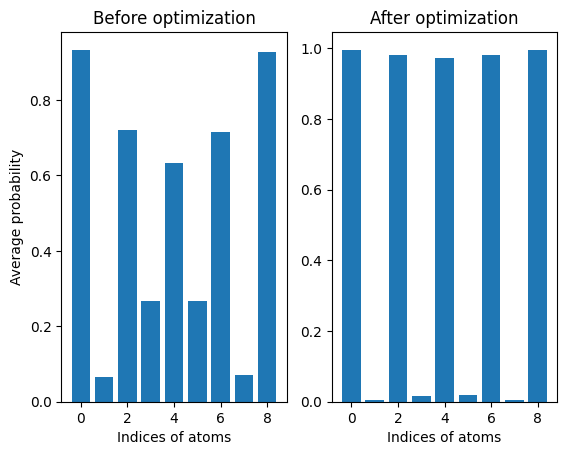

In [17]:
# Run the program with the optimized parameters for the detuning
counts_pl_optimized = program_pl(theta)
# Calculate the Rydberg density averaged over all the shots
prob_pl_optimized = get_prob(counts_pl_optimized)

fig, axs = plt.subplots(1, 2)
axs[0].bar(range(len(coords)), prob_pl)
axs[1].bar(range(len(coords)), prob_pl_optimized)
axs[0].set_xlabel("Indices of atoms")
axs[1].set_xlabel("Indices of atoms")
axs[0].set_ylabel("Average probability")
axs[0].set_title("Before optimization")
axs[1].set_title("After optimization")
plt.show()


Indeed, the AFM order after optimization exhibits a sharper alternating pattern compared to that before the optimization. We can also compare the detuning before and after the optimization, as shown below.

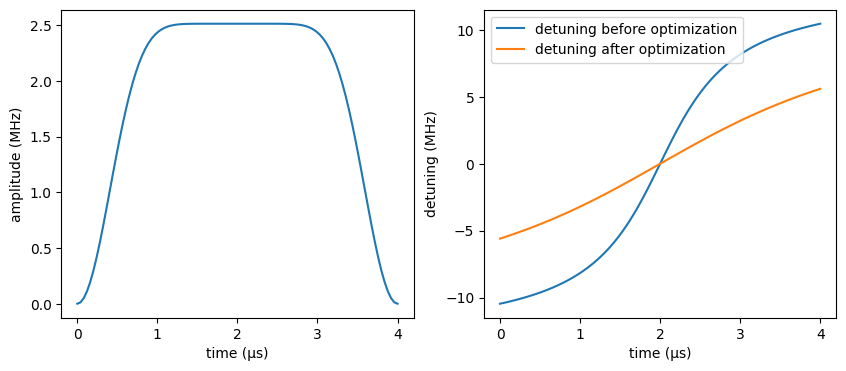

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(vis_time, [ryd_amplitude(amplitude_param, t) for t in vis_time])
axes[0].set_xlabel("time (μs)")
axes[0].set_ylabel("amplitude (MHz)")
axes[1].plot(vis_time, [ryd_detuning(detuning_param, t) for t in vis_time], label="detuning before optimization")
axes[1].plot(vis_time, [ryd_detuning(theta, t) for t in vis_time], label="detuning after optimization")
axes[1].set_ylabel("detuning (MHz)")
axes[1].set_xlabel("time (μs)")
axes[1].legend()
plt.show()


The optimized detuning exhibits a smaller slope, particularly in the middle of the evolution, compared to that before the optimization. Hence the optimized AHS program suffers less non-adiabaticity and produces the almost ideal AFM order. 

## Running on Aquila
To illustrate the usefulness of optimizing the AHS program, we now run the two AHS programs, before and after the optimization, on QuEra’s Aquila device and compare the results. This can be done by switching to QuEra’s Aquila device as shown below.


In [19]:
aquila = qml.device(
    "braket.aws.ahs",
    device_arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila",
    wires=len(coords),
)

program_cost_aquila = qml.QNode(program, aquila)

counts_aquila_before = program_cost_aquila(detuning_param)
counts_aquila_after = program_cost_aquila(theta)


Before calculating the Rydberg probability for the results obtained from Aquila, we need to process the counts such that it has consistent format with the counts from PennyLane local simulator. Besides, due to the noise in the real quantum device, certain shot result may contain 
`nan`, from which we cannot determine if the atom is in the ground or Rydberg state. Hence, we will discard shot result that contains `nan`. 

In [20]:
def process_aquila_counts(counts_aquila):
    """Process the counts from Aquila before calculating the Rydberg probability

        Note 1: For the counts returned from Aquila, a Rydberg state is indicated as
                `1.0` instead of `1`. We will convert it to `1` for consistency with 
                the counts returned from PennyLane local simulator. Similarly, we will
                convert `0.0` to `0` for the ground state.
        
        Note 2: For the counts returned from Aquila, certain shot result may contain 
                'nan' in addition to '1' or '0', due to the noise in the device. For 
                shot result contains 'nan', we will not include it in the calculation 
                of Rydberg probability. 
                

    """
    counts_aquila_updated = {}
    
    for key, val in counts_aquila.items():
        newkey = [key[i:i+3] for i in range(0, len(key), 3)]

        if 'nan' in newkey:
            # We throw away the shot result if it contains a 'nan'
            pass
        else: 
            for ind in range(len(newkey)):
                if newkey[ind] == '1.0':
                    newkey[ind] = '1'
                elif newkey[ind] == '0.0':
                    newkey[ind] = '0'

            newkey = ''.join(newkey)
            # print(newkey)

            counts_aquila_updated[newkey] = val    
            
    return counts_aquila_updated

In [21]:
counts_aquila_before_updated = process_aquila_counts(counts_aquila_before)
counts_aquila_after_updated = process_aquila_counts(counts_aquila_after)

We compare the AFM orders obtained from Aquila, before and after the optimization.

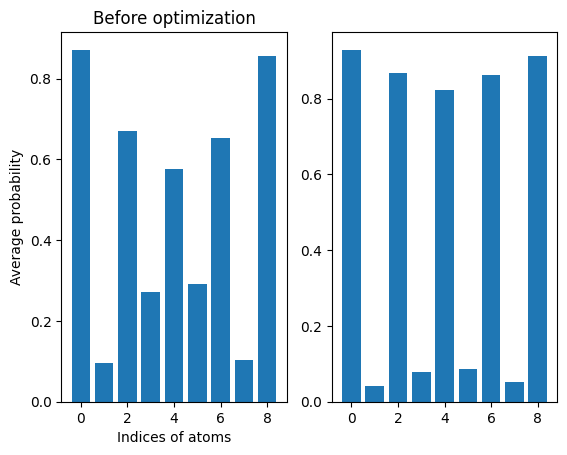

In [22]:
prob_aquila_before = get_prob(counts_aquila_before_updated)
prob_aquila_after = get_prob(counts_aquila_after_updated)


fig, axs = plt.subplots(1, 2)
axs[0].bar(range(len(coords)), prob_aquila_before)
axs[1].bar(range(len(coords)), prob_aquila_after)
axs[0].set_xlabel("Indices of atoms")
# axs[1].set_xlabel("Indices of atoms")
axs[0].set_ylabel("Average probability")
axs[0].set_title("Before optimization")
# axs[1].set_title("After optimization")
plt.show()


We find that the optimized AHS program indeed yields an AFM order that is much closer to an ideal one, compared to the non-optimized AHS program. This suggests that for AHS programs with small number of atoms, one can optimize it on the local simulator efficiently with the available machineries from PennyLane, before submitting it to the actual hardware. 

## Conclusion
This concludes our demonstration of running and optimizing AHS program on Rydberg device via the PennyLane-Braket plug-in. Following the methods in this post, one can implement incrementally complex parametrizations and optimizations for AHS programs. For instance, with small changes of the code above, one can optimize both the detuning and amplitude for the Rydberg atom device. We also encourage the interested readers to come up with different parametrizations for the driving field, which may be useful to realize other phases of matter with Rydberg atoms.


In [23]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:us-east-1::device/qpu/quera/Aquila': {'shots': 2000, 'tasks': {'COMPLETED': 2}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 20.60 USD
